This notebook evaluates whether a given image transformation successfully morphs a lion (class 291) to a water buffalo (class 346).

In [1]:
import torch
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from torchvision import transforms as T
from torchvision.models import resnet34, ResNet34_Weights

In [2]:
img_dirs = list(Path("./").glob("my_output_*/*"))
imgs = [Image.open(img_dir) for img_dir in img_dirs]
len(imgs)

16

In [3]:
def plot(imgs, img_dirs):
    plt.figure(figsize=(4 * len(imgs), 4))  # width x height in inches

    for idx, (img_dir, img) in enumerate(zip(img_dirs, imgs)):
        plt.subplot(1, len(imgs), idx + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(str(img_dir))

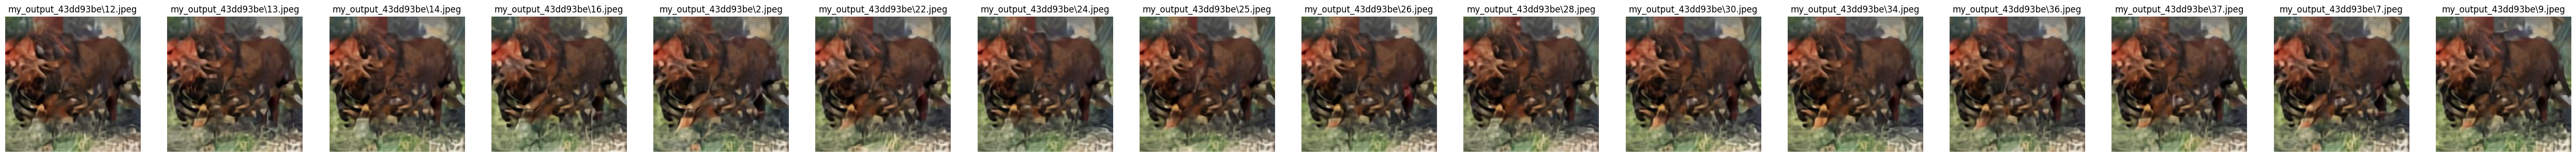

In [4]:
plot(imgs, img_dirs)

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
resnet = resnet34(weights=ResNet34_Weights.DEFAULT).to(device).eval()

In [6]:
@torch.no_grad()
def buffalo_score(images):
    if len(images) == 0:
        return torch.tensor([], dtype=torch.float, device=device)

    images = [transform(image).to(device) for image in images]
    images = torch.stack(images, dim=0)

    output = resnet(images).sigmoid()[:, [291, 346]]
    output = torch.softmax(output, dim=1)

    return output[:, 1].flatten()

In [7]:
scores = buffalo_score(imgs)
scores

tensor([0.4986, 0.4996, 0.5000, 0.4962, 0.4619, 0.5002, 0.4993, 0.4988, 0.4977,
        0.4996, 0.4971, 0.4990, 0.4995, 0.4979, 0.4956, 0.4971],
       device='cuda:0')

In [8]:
success_mask = scores >= 0.5
success_mask.any().item()  # Any success morphing?

True

In [9]:
def filter_(arr, mask):
    return [item for item, keep in zip(arr, mask) if keep]

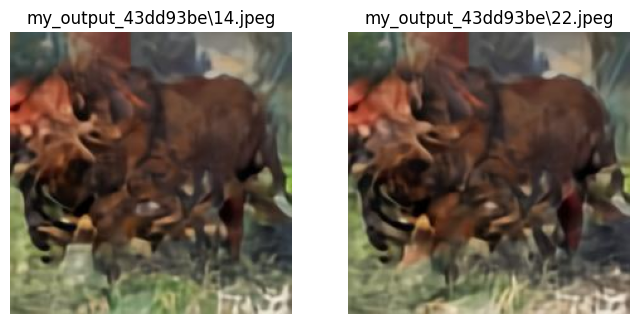

In [10]:
plot(filter_(imgs, success_mask), filter_(img_dirs, success_mask))  # Success images

In [11]:
scores[success_mask].tolist()

[0.5000271797180176, 0.5001922845840454]